<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/simplifiedCCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, zscore
from scipy.optimize import minimize

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Import dataset
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/cci.csv'
)
df.columns = df.columns.str.replace(' ', '') #Remove blank space
df.head(5)

,Month,N,Aging,Aging12
0,1,13109,0,0
1,1,322,0,1
2,1,71,0,2
3,1,23,0,3
4,1,230,0,4


### Downgrade or Default Probability (DDP)
The transition matrix is a multi-dimensional variable, it cannot be directly estimate a relationship with linear regression model. Thus, there needs to be an uni-dimensional variable, which can indicator the credit risk shared by all borrowers in a particular time period. Therefore, it is the best represented by the Downgrade or Default Probability (DDP) of the portfolio, which is given by the following expression:


\begin{align}
        DDP_t = \frac{\text{Number of downgrade or default observation at time period}_t}{\text{Total number of observation at time period}_t}
    \end{align}

In [4]:
# Downgrade flag
df['DDP'] = np.where(
    df['Aging12'] > df['Aging'],
    1,
    0
)
df.head(5)

,Month,N,Aging,Aging12,DDP
0,1,13109,0,0,0
1,1,322,0,1,1
2,1,71,0,2,1
3,1,23,0,3,1
4,1,230,0,4,1


### Credit Cycle Index (CCI)
The CCI is then computed by standardised DDP. Standardisation implies subtracting the mean from the actual value and then dividing by the standard deviation (Z-Score). In this case, standardisation can be expressed by the following formula:


\begin{align}
        CCI_t = -\left(\frac{\Phi^{-1}(DDP_t) - \mu(\Phi^{-1}(DDP_t))}{\sigma(\Phi^{-1}(DDP_t))}\right)
    \end{align}


where;
- $\Phi^{-1}$ is an inverse cumulative distribution function for a standard normal variable.
- $\mu$ is the mean of the inverse cumulative distribution function for a standard normal variable.
- $\sigma$ is the standard deviation of the inverse cumulative distribution function for a standard normal variable.

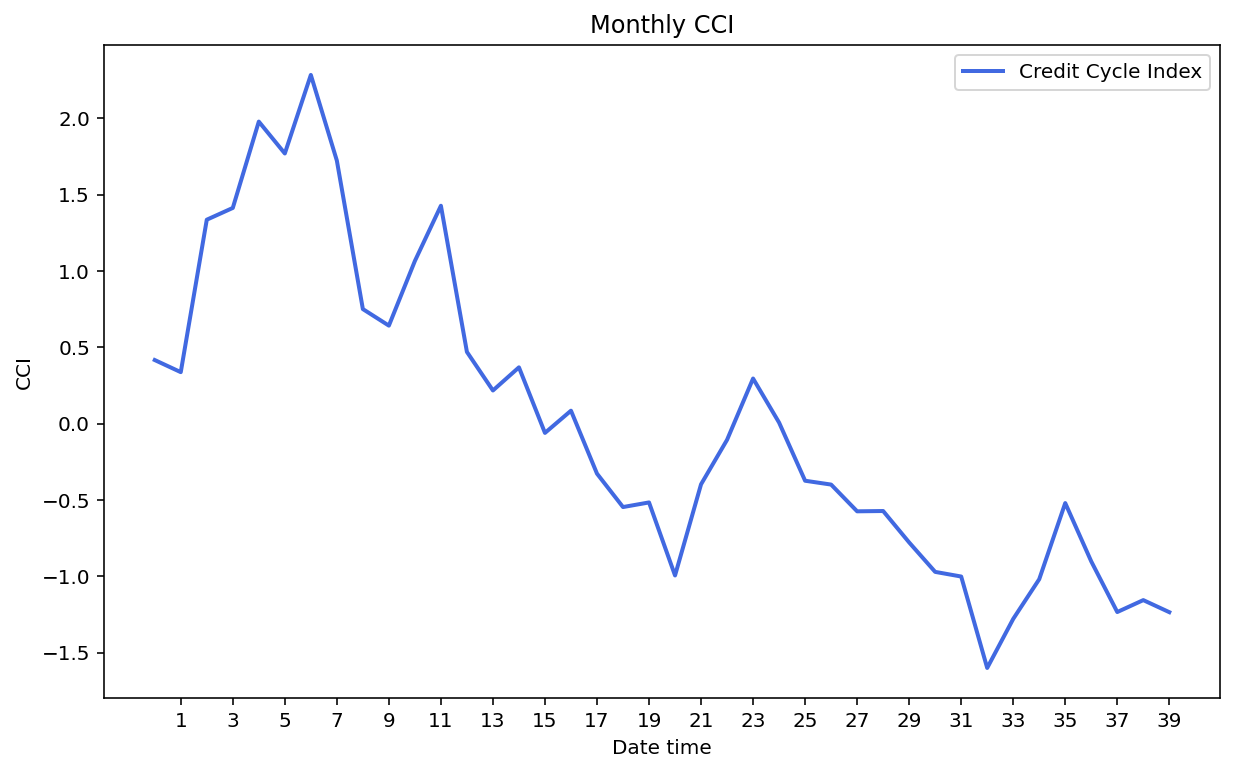

In [5]:
# CCI
cci = -zscore(
    norm.ppf(
        df[df['DDP'] == 1].groupby(
            ['Month']
        )['N'].sum() / \
        df.groupby(
            ['Month']
        )['N'].sum()
    )
)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    cci,
    c = 'royalblue',
    linewidth = 2,
    label = 'Credit Cycle Index'
)
plt.xticks(
    np.arange(1, cci.shape[0] + 1, 2)
)
plt.title('Monthly CCI')
plt.xlabel('Date time')
plt.ylabel('CCI')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [6]:
# Create average matrix
averageMatrix = (
    df.groupby(
        ['Aging', 'Aging12']
    )['N'].sum() / \
    df.groupby(
        ['Aging']
    )['N'].sum()
).rename('Rate').reset_index()

# Show table
averageMatrix.head(5)

,Aging,Aging12,Rate
0,0,0,0.947235
1,0,1,0.022953
2,0,2,0.006283
3,0,3,0.003005
4,0,4,0.020524


In [7]:
# Define plot matrix function
def plotMatrix(data, plotName, format):
  plt.figure(figsize = (10, 6))
  plt.title(f'{plotName}')
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = format,
      xticklabels = True,
      yticklabels = True,
      cmap = 'RdYlGn_r',
      cbar = False
  )
  ax.xaxis.tick_top() # x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

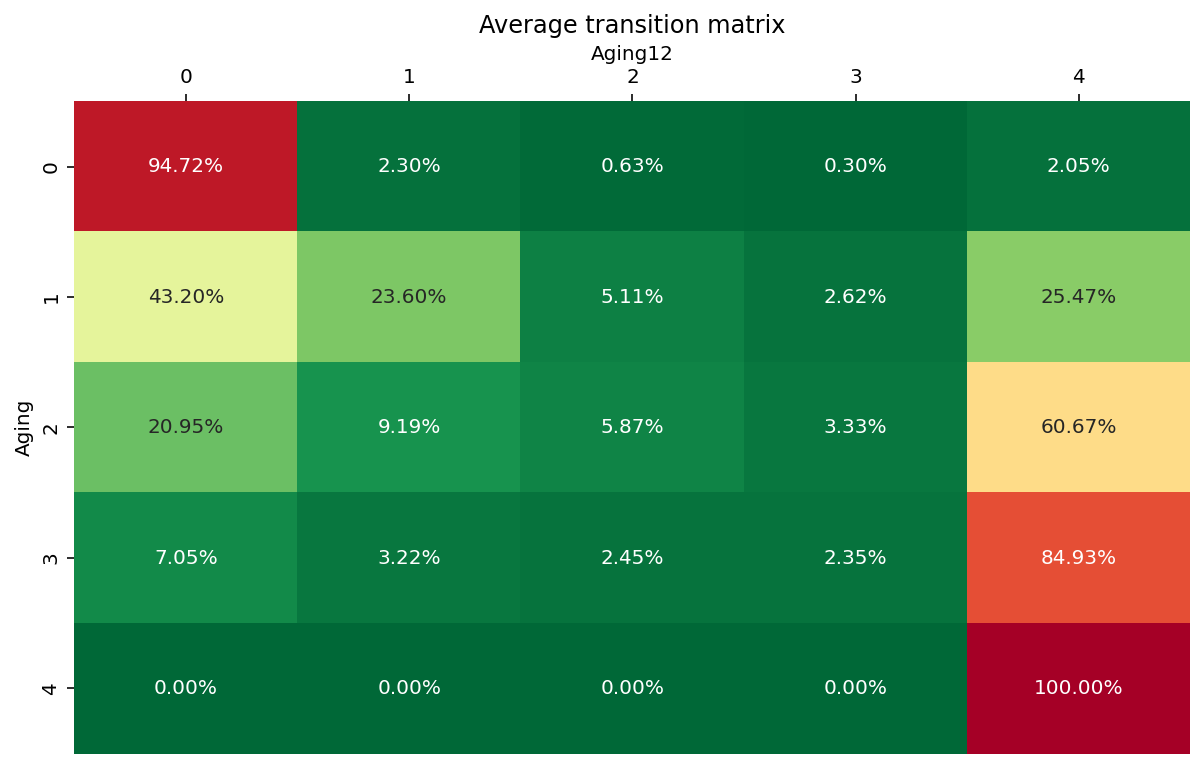

In [8]:
# Plot average transition matrix
plotMatrix(
    pd.pivot_table(
        averageMatrix,
        values = 'Rate',
        index = ['Aging'],
        columns = ['Aging12'],
        aggfunc = sum
    ).fillna(0),
    'Average transition matrix',
    '.2%'
)

In [9]:
# Create upper matrix threshold
averageMatrix['Survive'] = 1 - averageMatrix.groupby(['Aging'])['Rate'].cumsum()
averageMatrix['Upper'] = norm.ppf(
    averageMatrix.groupby(
        ['Aging'], sort = False
    )['Survive'].shift(1).fillna(0)
)

### Unconditional thresholds estimation (Upper thresholds)
The underlying assumption of this methodology is that the movement of a contract follows a standard normal distribution (figure below) and the transitions are described through a set of thresholds placed on x-axis (i.e. risk grading (aging). The thresholds will vary for different buckets and the transition rates are equal to the area enclosed by the boundaries of the bin and the density function.

![standard normal distribution](https://cdn.scribbr.com/wp-content/uploads/2020/10/standard-normal-distribution-768x475.png)

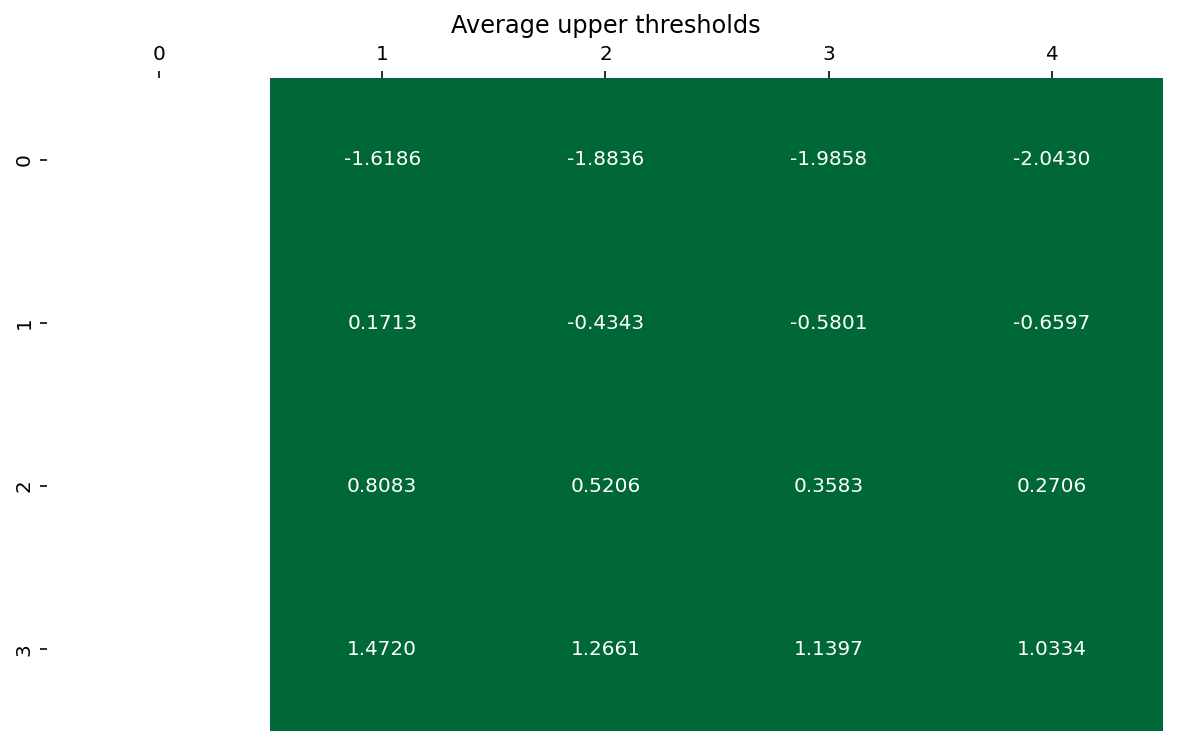

In [10]:
# Convert to numpy array
# Upper matrix array
upperArray = averageMatrix[averageMatrix['Aging'] != 4] #Drop default at observation
upperArray = pd.pivot_table(
    upperArray,
    values = 'Upper',
    index = ['Aging'],
    columns = ['Aging12']
).fillna(0) #Missing observation
upperArray = upperArray.to_numpy()

# Plot upper array
plotMatrix(
    upperArray,
    'Average upper thresholds',
    '.4f'
)

In [11]:
# Create monthly matrix
monthlyMatrix = (
    df.groupby(
        ['Month', 'Aging', 'Aging12']
    )['N'].sum() / \
    df.groupby(
        ['Month', 'Aging']
    )['N'].sum()
).rename('Rate').reset_index()

# Show table
monthlyMatrix.head(5)

,Month,Aging,Aging12,Rate
0,1,0,0,0.953035
1,1,0,1,0.023410
2,1,0,2,0.005162
3,1,0,3,0.001672
4,1,0,4,0.016721


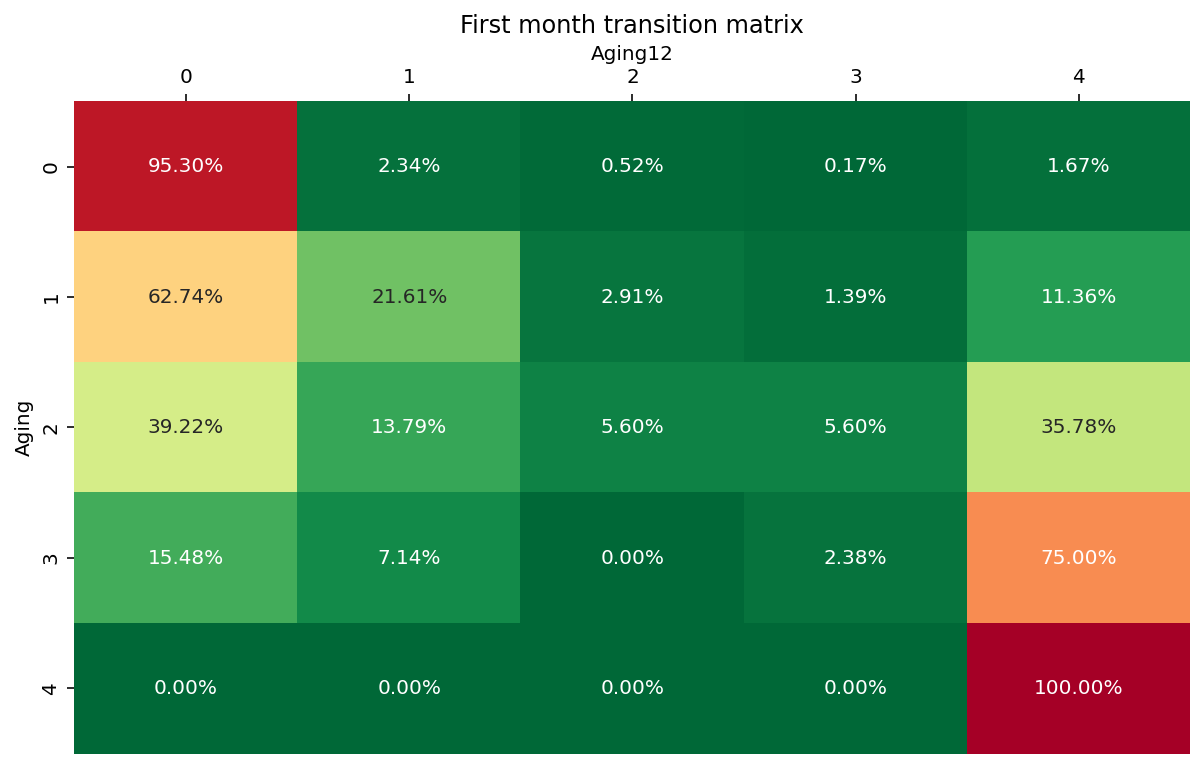

In [12]:
# Plot monthly transition matrix
plotMatrix(
    pd.pivot_table(
        monthlyMatrix[monthlyMatrix['Month'] == 1], #First month
        values = 'Rate',
        index = ['Aging'],
        columns = ['Aging12'],
        aggfunc = sum
    ).fillna(0),
    'First month transition matrix',
    '.2%'
)

In [13]:
# Monthly array
monthlyArray = monthlyMatrix[monthlyMatrix['Aging'] != 4] #Drop default at observation
monthlyArray = pd.pivot_table(
    monthlyArray,
    values = 'Rate',
    index = ['Month', 'Aging'],
    columns = ['Aging12']
).fillna(0) #Missing observation in month
monthlyArray = monthlyArray.to_numpy().reshape(df['Month'].max(), -1)
print(f'Total monthly transition shape: {monthlyArray.shape}')
print('First month transition matrix array')
monthlyArray[0] #Show first month transition matrix

Total monthly transition shape: (40, 20)
First month transition matrix array


array([0.95303526, 0.02340967, 0.00516176, 0.00167212, 0.01672119,
       0.62742382, 0.21606648, 0.02908587, 0.01385042, 0.11357341,
       0.39224138, 0.13793103, 0.05603448, 0.05603448, 0.35775862,
       0.1547619 , 0.07142857, 0.        , 0.02380952, 0.75      ])

### Conditional transition matrix
The unconditional thresholds (upper array) will be used to produce conditional transition matrices by the formula below:

\begin{align}
        P(i,j | Z_{t}) = \Phi\left(\frac{x_{j+1}^{i} - \rho Z_{t}}{\sqrt{1 - \rho^{2}}}\right) - \Phi\left(\frac{x_{j}^{i} - \rho Z_{t}}{\sqrt{1 - \rho^{2}}}\right)
    \end{align}


where;
- $P(i,j | Z_{t})$ is the inverse cumulative distribution function for a standard normal variable.
- $Z_{t}$ is the CCI Value at time period t.
- $x$ is the transition rate.
- $\Phi$ is the cumulative distribution function of standard normal variable.
- $\rho$ is the influence of the economy on the portfolio’s default and downgrade probabilities.

The $\rho$ values will be estimated by minimizing the squared errors between unbiased transition rates and conditional transition rates from the above formula, given 0 ≤ $\rho$ ≤ 1

The **maximum** error between unbiased and conditional transition rates are computed for **each risk grade** of **each time** by taking the square of the differences between the unbiased transition rates and conditional transition rates. It is referred as the squared errors (SE), which can be computed by the formula below. Example of the calculation are also shown below:

\begin{align}
        SE = (\text{Unbiased transition rate} - \text{Conditional transition rate})^{2}
    \end{align}

In [14]:
# Rho optimisation
# Define Rho function
def Rho(x):
  monthlyFitted = []
  for i in range(cci.shape[0]):
    fittedUpper = (upperArray - (x * cci[i])) / np.sqrt(1 - x ** 2)
    monthlyFitted.append(fittedUpper)
  monthlyFitted = np.vstack(monthlyFitted)
  # Fitted matrix
  cdfMonthly = [norm.cdf(monthlyFitted[0:, i]) for i in range(1, 5)] #Cumulative matrix
  fittedMatrix = np.stack(
      (
          1 - cdfMonthly[0],
          cdfMonthly[0] - cdfMonthly[1],
          cdfMonthly[1] - cdfMonthly[2],
          cdfMonthly[2] - cdfMonthly[3],
          cdfMonthly[3]
      ),
      axis = 1
  )
  fittedMatrix = fittedMatrix.reshape(cci.shape[0], -1)
  # Error matrix
  errorMatrix = ((monthlyArray - fittedMatrix) ** 2).reshape(-1, 5) #Reshape to aging and month
  maxError = errorMatrix.max(axis = 1) #Maximum error by aging and month
  agingIndex = monthlyMatrix[monthlyMatrix['Aging'] != 4].groupby(['Month', 'Aging'])['Rate'].count().index #Get index for key
  maxError = pd.DataFrame(
      maxError,
      columns = ['Error'],
      index = agingIndex
  ).reset_index()
  error = maxError.groupby(['Aging'])['Error'].mean().sum()
  return error

# Define minimize error
def findRho(x):
  return Rho(x)

In [15]:
# Initial guess
x0 = np.random.uniform() #Guess Rho (0, 1)

# Boundaries between 0-1
bound = [(0., 1.)]

# Set option for iteration
options = {
    'maxiter': 10000,
    'disp': True
} #Increase number of iteration

In [16]:
# Finding Rho
optRho = minimize(
    findRho,
    x0,
    method = 'SLSQP',
    bounds = bound,
    options = options
)
optRho

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015734642183089818
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 6


     fun: 0.015734642183089818
     jac: array([-0.00075412])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.18774814])

In [17]:
# Fitting matrix with Rho
rho = optRho.x[0]

# Define function fitting matrix
def fittingMatrix(month):
  monthlyFitted = []
  fittedUpper = (upperArray - (rho * cci[month])) / np.sqrt(1 - rho ** 2)
  cdfMonthly = [norm.cdf(fittedUpper[0:, i]) for i in range(1, 5)]
  fittedMatrix = np.stack(
      (
          1 - cdfMonthly[0],
          cdfMonthly[0] - cdfMonthly[1],
          cdfMonthly[1] - cdfMonthly[2],
          cdfMonthly[2] - cdfMonthly[3],
          cdfMonthly[3]
      ),
      axis = 1
  )
  return pd.DataFrame(fittedMatrix)

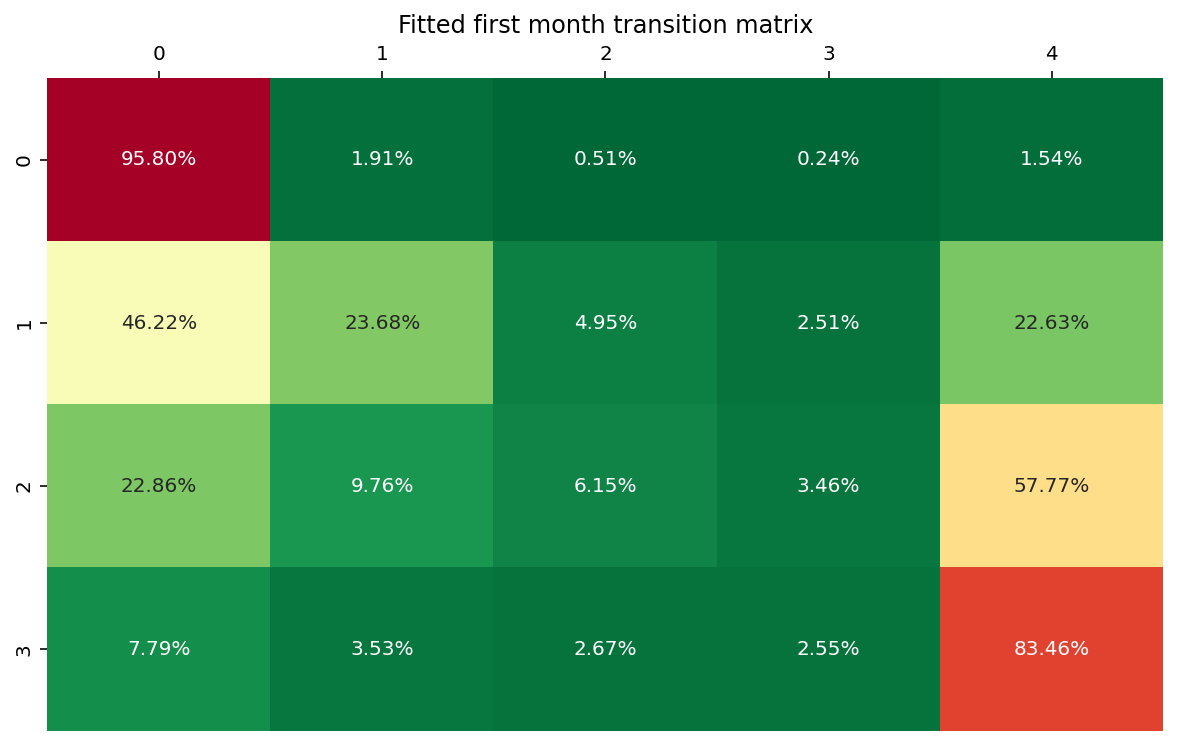

In [18]:
# Fitting with first month
plotMatrix(
    fittingMatrix(0),
    'Fitted first month transition matrix',
    '.2%'
)